<a href="https://colab.research.google.com/github/ZEBAAFROZ/Grad_CAM/blob/main/GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Grad-CAM**

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
pip show numpy tensorflow matplotlib IPython

Name: numpy
Version: 1.23.5
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: albumentations, altair, arviz, astropy, autograd, blis, bokeh, bqplot, chex, cmdstanpy, contourpy, cufflinks, cvxpy, datascience, db-dtypes, dopamine-rl, ecos, flax, folium, geemap, gensim, gym, h5py, holoviews, hyperopt, imageio, imbalanced-learn, imgaug, jax, jaxlib, librosa, lightgbm, matplotlib, matplotlib-venn, missingno, mizani, ml-dtypes, mlxtend, moviepy, music21, nibabel, numba, numexpr, opencv-contrib-python, opencv-python, opencv-python-headless, opt-einsum, optax, orbax-checkpoint, osqp, pandas, pandas-gbq, patsy, plotnine, prophet, pyarrow, pycocotools, pyerfa, pymc, pytensor, python-louvain, PyWavelets, qdldl, qudida, scikit-image, scikit-learn, scipy, scs, seaborn, shapely, sklearn-pandas, soxr, spacy, s

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

In [ ]:
model_builder = keras.applications.vgg16.VGG16
img_size = (224,224)
preprocess_input = keras.applications.vgg16.preprocess_input
decode_predictions = keras.applications.vgg16.decode_predictions

In [ ]:
model=VGG16()

In [ ]:
model.summary()

In [ ]:
last_conv_layer_name = "block5_conv3"


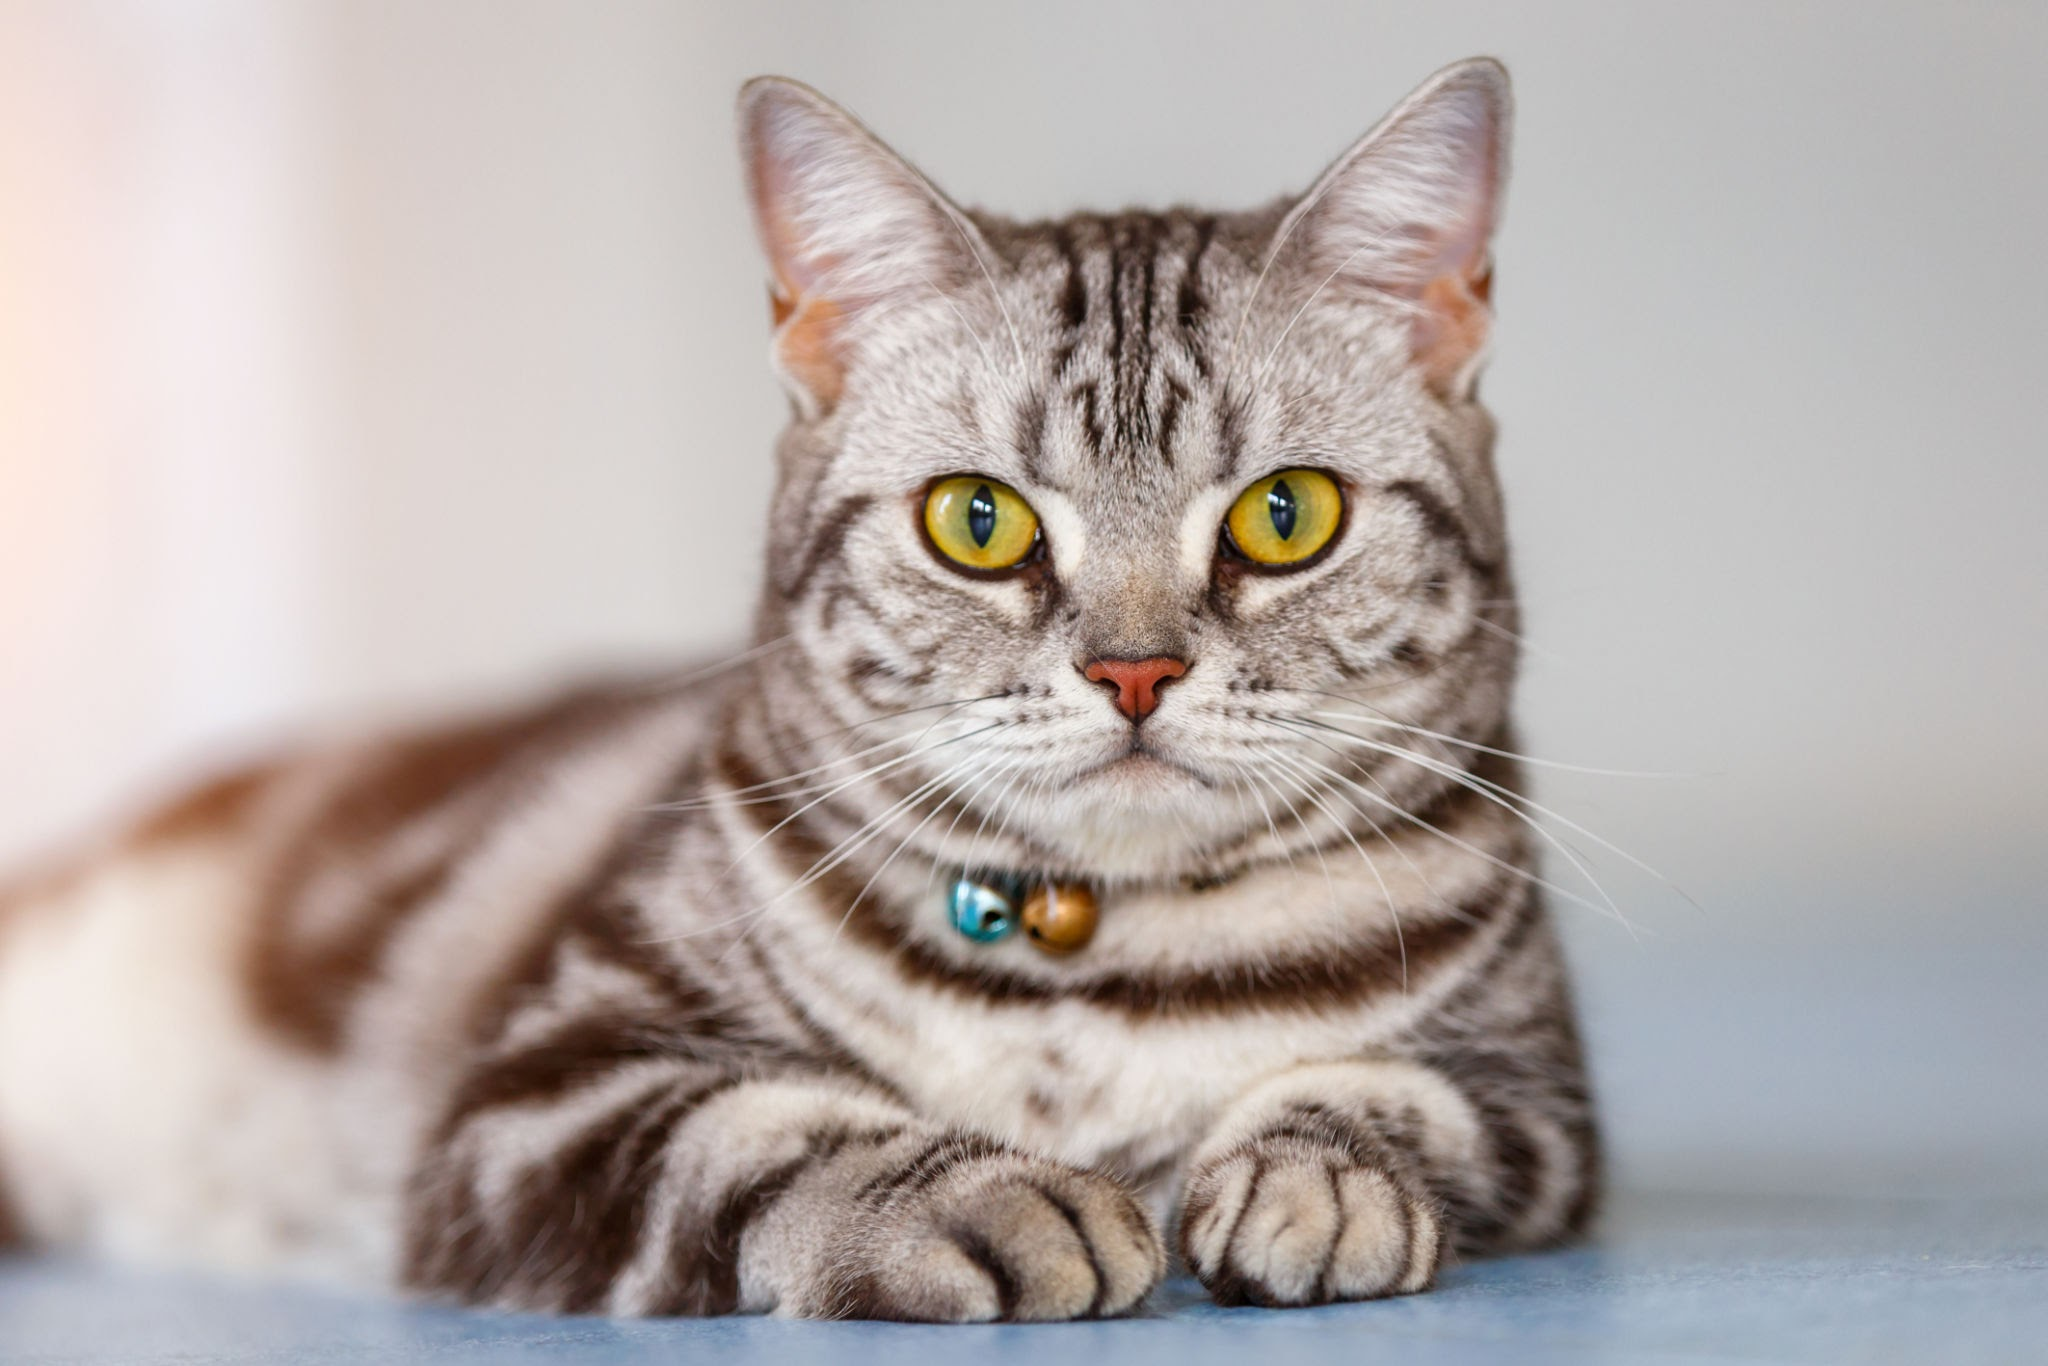

In [ ]:
# The local path to our target image
img_path = keras.utils.get_file(
    "cat.jpg", "https://encrypted-tbn1.gstatic.com/licensed-image?q=tbn:ANd9GcTirTLZGJkc8CsFcR-FTUBvCuK0oW4Qlbi5zSZqfjdo8HBf8xWkrYv9M2QP0Ekpc9HGXe8l39aQZx95Od8"
)

display(Image(img_path))

227079/227079 [==============================] - 0s 0us/step


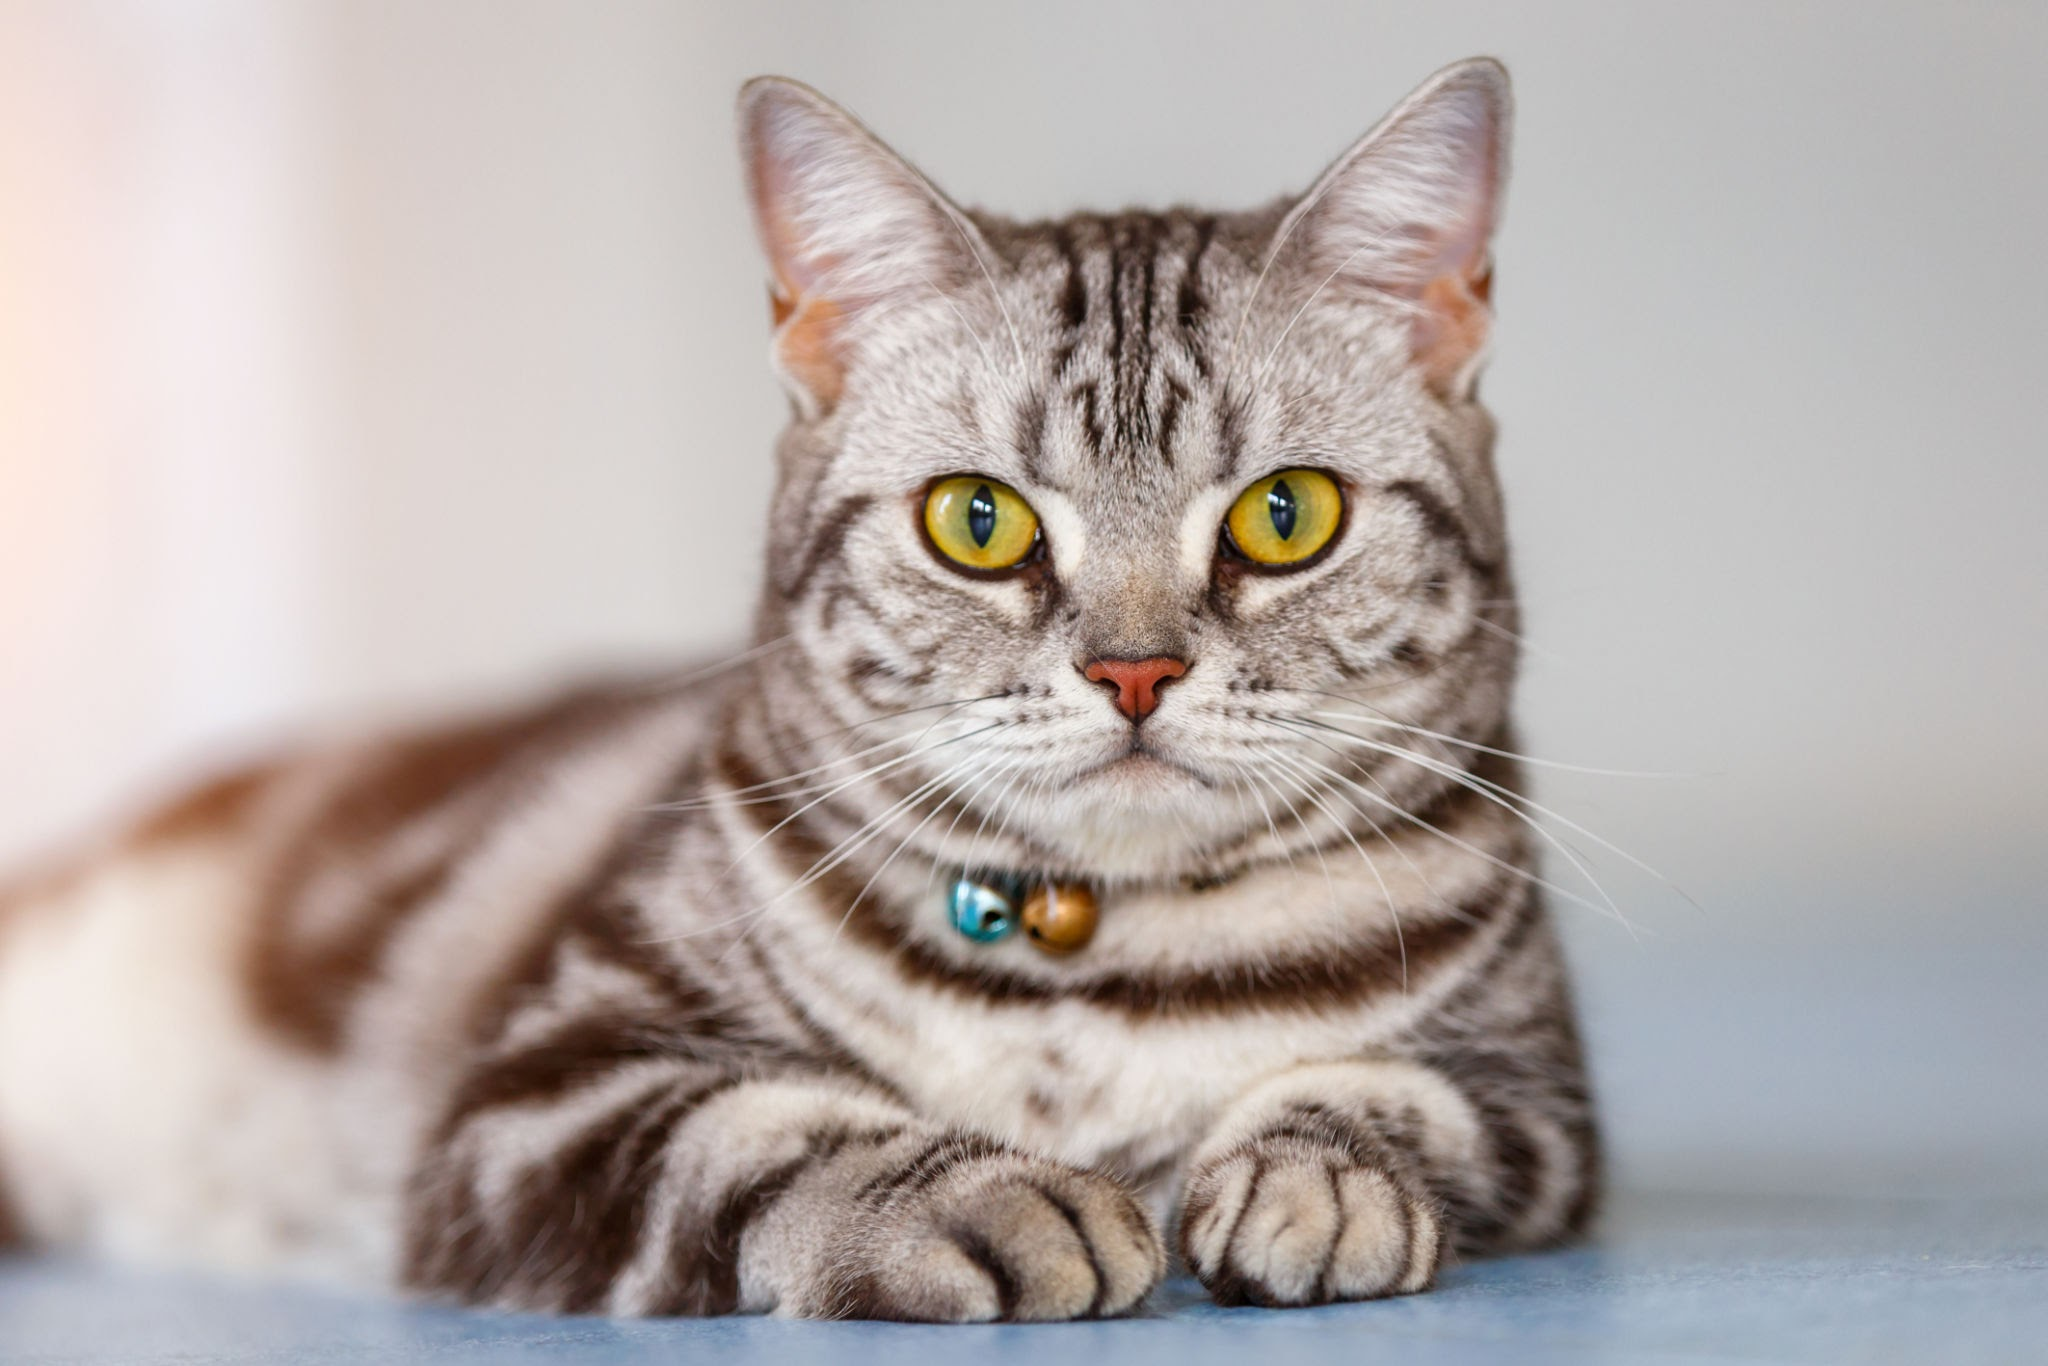

In [ ]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
img_path = keras.utils.get_file(
    "cat.jpg", "https://encrypted-tbn1.gstatic.com/licensed-image?q=tbn:ANd9GcTirTLZGJkc8CsFcR-FTUBvCuK0oW4Qlbi5zSZqfjdo8HBf8xWkrYv9M2QP0Ekpc9HGXe8l39aQZx95Od8"
)

display(Image(img_path))

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 [==============================] - 0s 151ms/step
Predicted: [('n02124075', 'Egyptian_cat', 13.570145)]


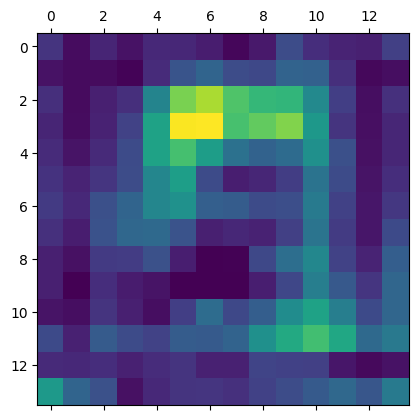

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


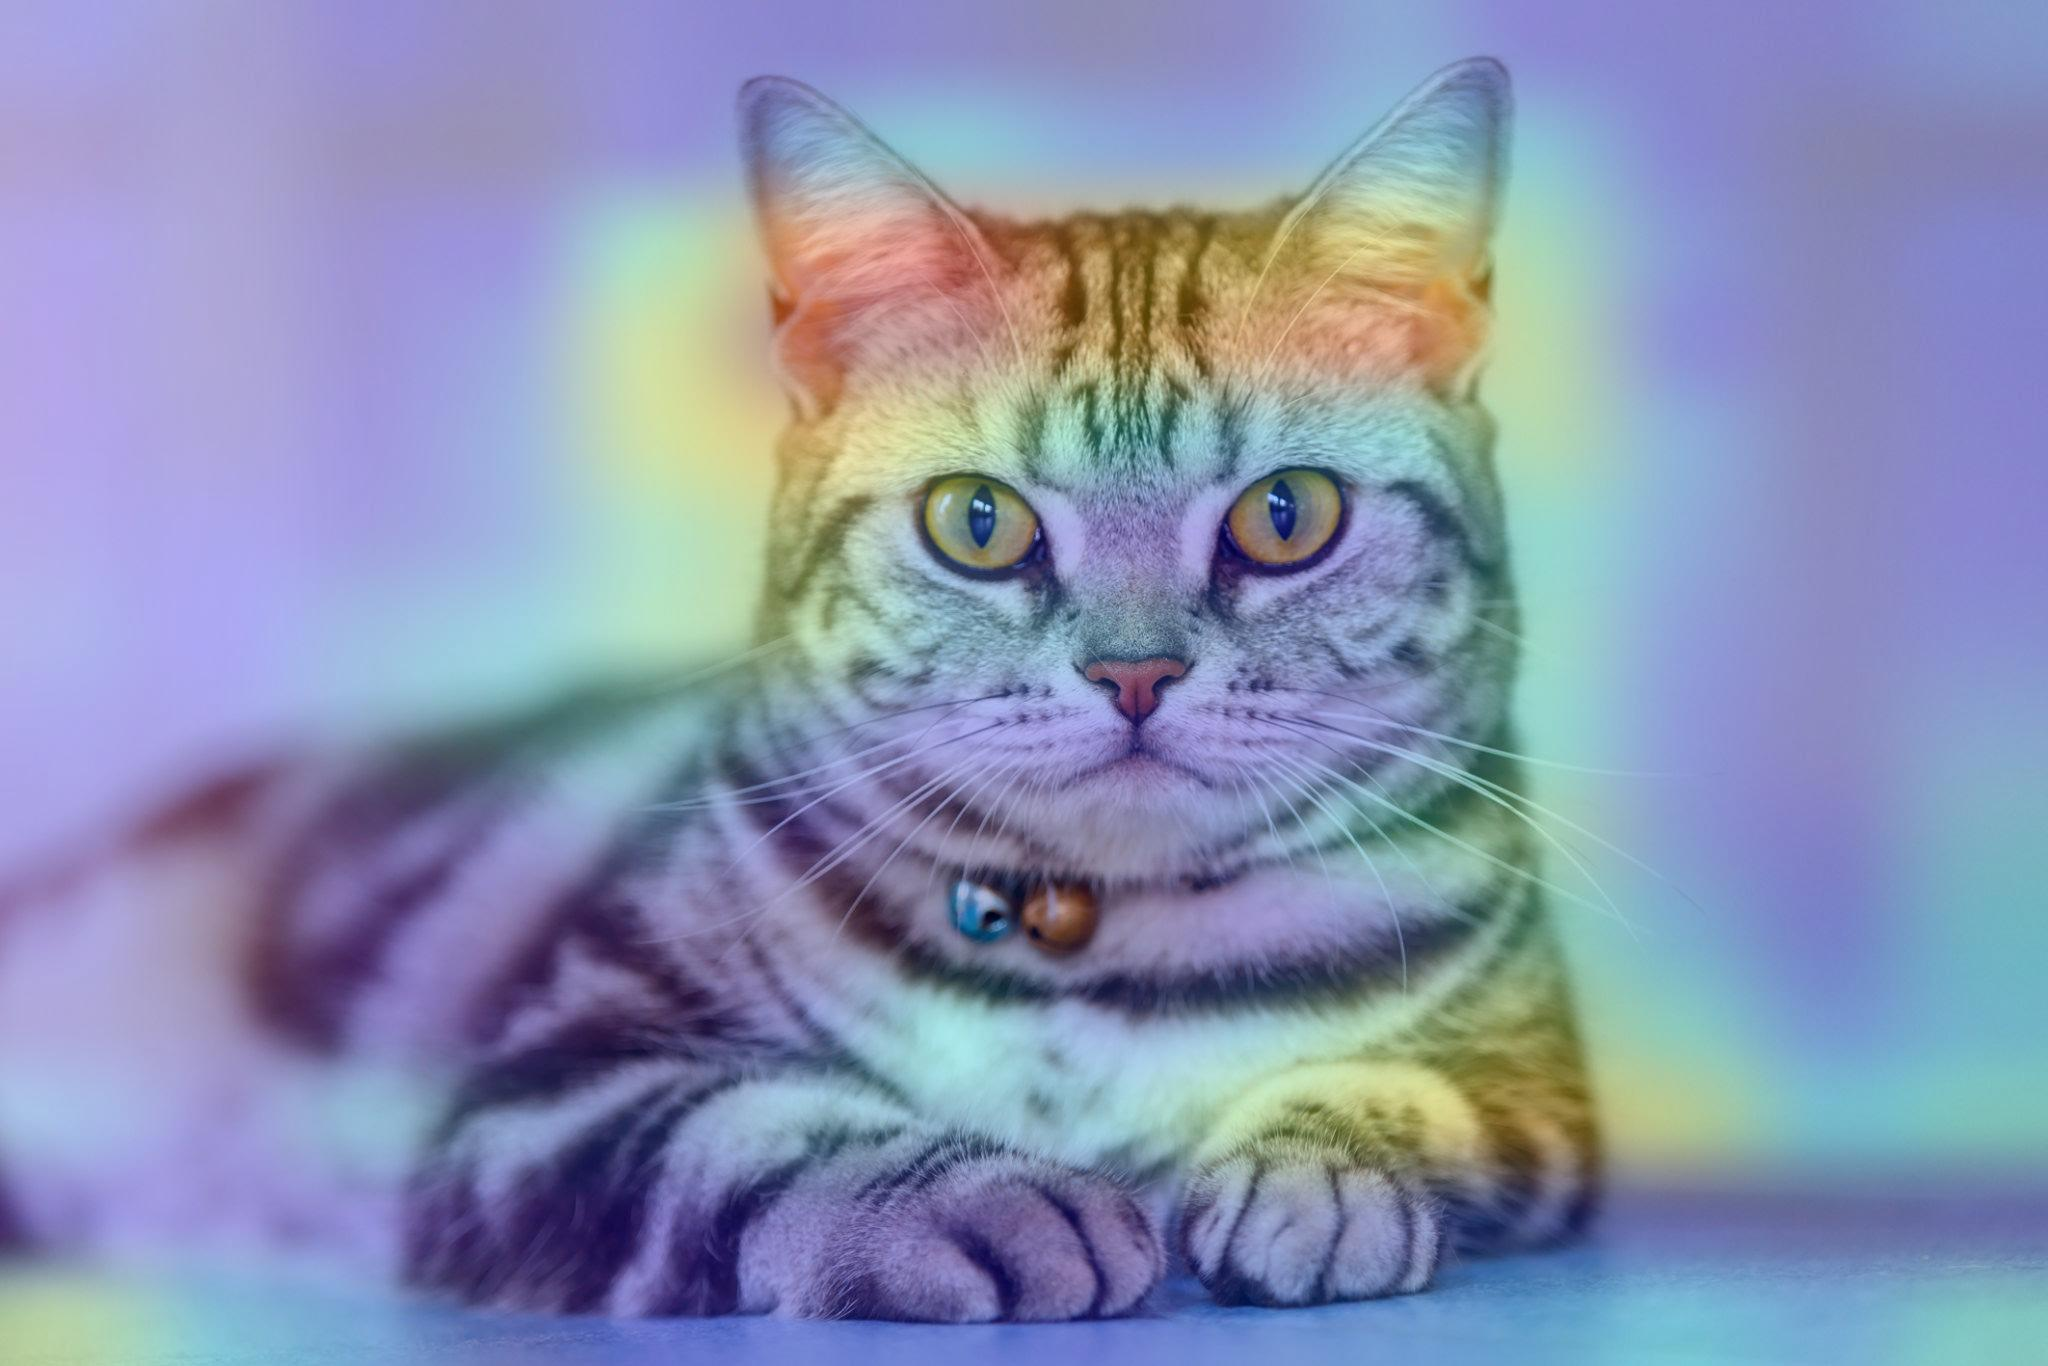

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)